# Imports and installs

In [1]:
import pandas as pd
import numpy as np
import keras as kr
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import neural_network
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Data 

## Load data



In [2]:
df_raw_confirmed_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_raw_deaths_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_raw_recovered_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

def renameColumns(df):
  col_list = df.columns.to_list()
  col_list[0] = "Province_State"
  col_list[1] = "Country_Region"
  df.columns = col_list

renameColumns(df_raw_confirmed_global)
renameColumns(df_raw_deaths_global)
renameColumns(df_raw_recovered_global)

## Choose country



In [3]:
def selectCountry(df, country):
  return df.query("Country_Region == '" + country + "' and Province_State != Province_State")

COUNTRY = "France"
df_confirmed_country = selectCountry(df_raw_confirmed_global, COUNTRY)
df_deaths_country = selectCountry(df_raw_deaths_global, COUNTRY)
df_recovered_country = selectCountry(df_raw_recovered_global, COUNTRY)

## Prepare data

In [4]:
def removeUselessColumns(df): 
  return df.drop(columns=["Lat", "Long", "Province_State", "Country_Region"])

def columnsInNumbers(df):
  df.columns = [i for i in range(len(df_confirmed_country.columns))]

df_confirmed_country = removeUselessColumns(df_confirmed_country)
df_deaths_country = removeUselessColumns(df_deaths_country)
df_recovered_country = removeUselessColumns(df_recovered_country)

columnsInNumbers(df_confirmed_country)
columnsInNumbers(df_deaths_country)
columnsInNumbers(df_recovered_country)

df_confirmed_country

,0,1,2,3,4,5,6,7,8,9,...,664,665,666,667,668,669,670,671,672,673
130,0,0,2,3,3,3,4,5,5,5,...,7128903,7149118,7168026,7188721,7211399,7231148,7235966,7266361,7296757,7330086


Préparation des données et des jours sous forme de tableaux :

In [5]:
def get_values_and_days(df):
  return (df.values[0], df.columns.to_list())

confirmed_country_values, confirmed_country_days = get_values_and_days(df_confirmed_country)
deaths_country_values, deaths_country_days = get_values_and_days(df_deaths_country)
recovered_country_values, recovered_country_days = get_values_and_days(df_recovered_country)

Affichage des données

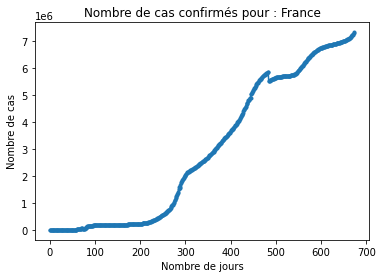

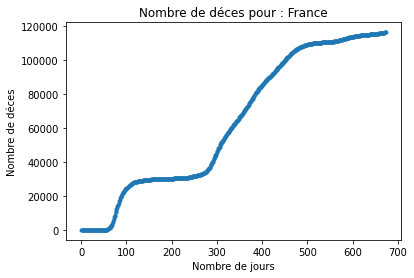

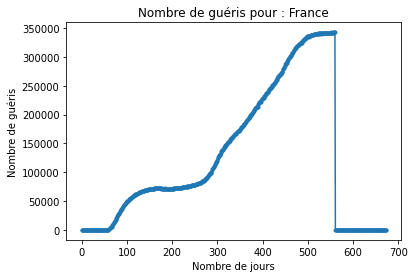

In [6]:
plt.plot(confirmed_country_days, confirmed_country_values, '.-')
plt.title("Nombre de cas confirmés pour : " + COUNTRY)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

plt.plot(deaths_country_days, deaths_country_values, '.-')
plt.title("Nombre de déces pour : " + COUNTRY)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de déces")
plt.show()

plt.plot(recovered_country_days, recovered_country_values, '.-')
plt.title("Nombre de guéris pour : " + COUNTRY)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de guéris")
plt.show()

Training and test sets

In [7]:
confirmed_train, confirmed_test, confirmed_train_days, confirmed_test_days = train_test_split(confirmed_country_values, confirmed_country_days, test_size=0.30)
deaths_train, deaths_test, deaths_train_days, deaths_test_days = train_test_split(deaths_country_values, deaths_country_days, test_size=0.30)
recovered_train, recovered_test, recovered_train_days, recovered_test_days = train_test_split(recovered_country_values, recovered_country_days, test_size=0.30)

# Fonction d'erreur par valeur absolue

In [8]:
def calc_error(reg, X, Y):
  abs = np.abs(np.reshape(reg.predict(X), (-1,)) - Y)
  return np.sum(abs) / len(Y)

# Regression polynomiale (degré = 2)

In [9]:
def regression(X, Y):
  reg = svm.SVR(kernel='poly', C=1000, degree=2)
  reg.fit(X, Y)
  return reg

reg_confirmed = regression(np.reshape(confirmed_train_days, newshape=(-1, 1)), confirmed_train)
reg_deaths = regression(np.reshape(deaths_train_days, newshape=(-1, 1)), deaths_train)
reg_recovered = regression(np.reshape(recovered_train_days, newshape=(-1, 1)), recovered_train)

print("Regression cas : ", reg_confirmed.score(np.reshape(confirmed_test_days, newshape=(-1, 1)), confirmed_test))
print("Regression morts : ", reg_deaths.score(np.reshape(deaths_test_days, newshape=(-1, 1)), deaths_test))
print("Regression guéris : ", reg_recovered.score(np.reshape(recovered_test_days, newshape=(-1, 1)), recovered_test))

Regression cas :  0.953966063369887
Regression morts :  0.8672244855227829
Regression guéris :  -1.7076139467024833


Erreur moyenne valeur absolue

In [10]:
print("Erreur moyenne regression cas : ", calc_error(reg_confirmed, np.reshape(confirmed_test_days, newshape=(-1, 1)), confirmed_test))
print("Erreur moyenne regression morts : ", calc_error(reg_deaths, np.reshape(deaths_test_days, newshape=(-1, 1)), deaths_test))
print("Erreur moyenne regression guéris : ", calc_error(reg_recovered, np.reshape(recovered_test_days, newshape=(-1, 1)), recovered_test))

Erreur moyenne regression cas :  454774.75436147564
Erreur moyenne regression morts :  11794.10081297327
Erreur moyenne regression guéris :  105132.34444143793


Visualisation des modèles

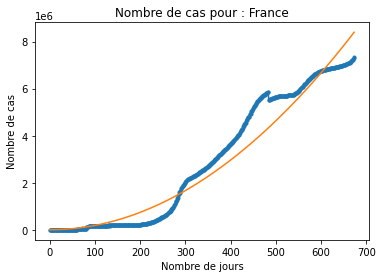

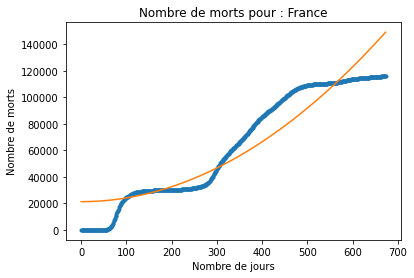

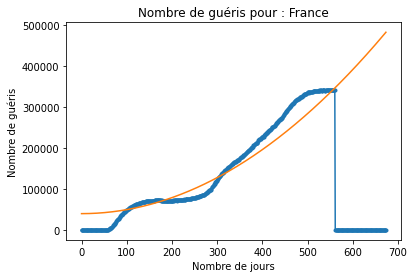

In [11]:
def display_plot(reg, X, Y, ord_context):
  plt.plot(X, Y, '.-')
  plt.plot(X, reg.predict(X), "-")
  plt.title("Nombre de " + ord_context + " pour : " + COUNTRY)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()

display_plot(reg_confirmed, np.reshape(confirmed_country_days, newshape=(-1, 1)), confirmed_country_values, "cas")
display_plot(reg_deaths, np.reshape(deaths_country_days, newshape=(-1, 1)), deaths_country_values, "morts")
display_plot(reg_recovered, np.reshape(recovered_country_days, newshape=(-1, 1)), recovered_country_values, "guéris")

# Réseaux LSTM

In [12]:
def create_sequences(data, time_steps=1):
  dataX, dataY = [], []
  for i in range(len(data)-time_steps):
    a = data[i:(i+time_steps)]
    dataX.append(a)
    dataY.append(data[i + time_steps][0])
  return np.array(dataX), np.array(dataY)
 
def create_lstm_sets(X, time_steps=1, scale=True):
  scaler=None
  if scale:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)
  else:
    scaled_X = np.array(X)
  train_size = int(len(scaled_X) * 0.75)
  test_size = len(scaled_X) - train_size
  train, test = scaled_X[0:train_size,:], scaled_X[train_size:len(scaled_X),:]
  return create_sequences(train, time_steps), create_sequences(test, time_steps), scaler

def lstm_network(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(150, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.3))
  model.add(kr.layers.LSTM(150))
  model.add(kr.layers.Dropout(0.3))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=50, batch_size=6);
  return model

## Variable monodimensionelle

In [13]:
time_steps = 1
n_features = 1

### Nombre de cas

In [14]:
confirmed_lstm_set = df_confirmed_country.values[0]
confirmed_lstm_set = np.reshape(confirmed_lstm_set, (len(confirmed_lstm_set), 1))

confirmed_train, confirmed_test, confirmed_scaler = create_lstm_sets(confirmed_lstm_set, time_steps)

confirmed_trainX, confirmed_trainY = confirmed_train
confirmed_testX, confirmed_testY = confirmed_test

confirmed_lstm = lstm_network(confirmed_trainX, confirmed_trainY, time_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 150)            91200     
                                                                 
 dropout (Dropout)           (None, 1, 150)            0         
                                                                 
 lstm_1 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 271,951
Trainable params: 271,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
84/84 [==============================] 

### Nombre de morts

In [15]:
deaths_lstm_set = df_deaths_country.values[0]
deaths_lstm_set = np.reshape(deaths_lstm_set, (len(deaths_lstm_set), 1))

deaths_train, deaths_test, deaths_scaler = create_lstm_sets(deaths_lstm_set, time_steps)
deaths_trainX, deaths_trainY = deaths_train
deaths_testX, deaths_testY = deaths_test

deaths_lstm = lstm_network(deaths_trainX, deaths_trainY, time_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 150)            91200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 150)            0         
                                                                 
 lstm_3 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 271,951
Trainable params: 271,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
84/84 [==============================

### Nombre de guéris

In [16]:
recovered_lstm_set = df_recovered_country.values[0]
recovered_lstm_set = np.reshape(recovered_lstm_set, (len(recovered_lstm_set), 1))

recovered_train, recovered_test, recovered_scaler = create_lstm_sets(recovered_lstm_set, time_steps)
recovered_trainX, recovered_trainY = recovered_train
recovered_testX, recovered_testY = recovered_test

recovered_lstm = lstm_network(recovered_trainX, recovered_trainY, time_steps)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 150)            91200     
                                                                 
 dropout_4 (Dropout)         (None, 1, 150)            0         
                                                                 
 lstm_5 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_5 (Dropout)         (None, 150)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 271,951
Trainable params: 271,951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
84/84 [==============================

### Affichage des résultats

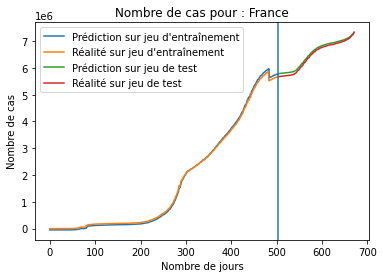

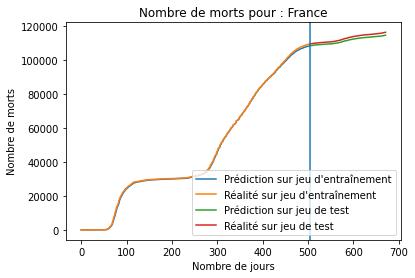

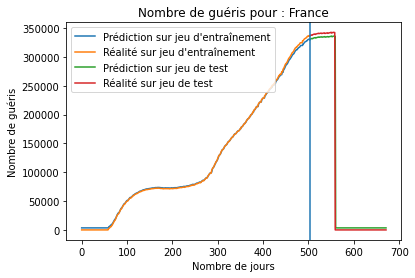

In [17]:
def display_plot_lstm(model, scaler, trainX, trainY, testX, testY, country, ord_context):
  daysTrain = range(len(trainX))
  daysTest = np.array(range(len(testX))) + len(daysTrain)
  plt.plot(daysTrain, scaler.inverse_transform(model.predict(trainX)), '-', label="Prédiction sur jeu d'entraînement")
  plt.plot(daysTrain, scaler.inverse_transform(np.reshape(trainY, (-1, 1))), '-', label="Réalité sur jeu d'entraînement")

  plt.plot(daysTest, scaler.inverse_transform(model.predict(testX)), '-', label="Prédiction sur jeu de test")
  plt.plot(daysTest, scaler.inverse_transform(np.reshape(testY, (-1, 1))), '-', label="Réalité sur jeu de test")

  plt.axvline(len(trainX), 0, 1)
  plt.legend()
  plt.title("Nombre de " + ord_context + " pour : " + country)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()
  
display_plot_lstm(confirmed_lstm, confirmed_scaler, confirmed_trainX, confirmed_trainY, confirmed_testX, confirmed_testY, COUNTRY, "cas")
display_plot_lstm(deaths_lstm, deaths_scaler, deaths_trainX, deaths_trainY, deaths_testX, deaths_testY, COUNTRY, "morts")
display_plot_lstm(recovered_lstm, recovered_scaler, recovered_trainX, recovered_trainY, recovered_testX, recovered_testY, COUNTRY, "guéris")

### Calcul de l'erreur

In [18]:
def calc_error_lstm(lstm_model, scaler, X, Y):
  return np.reshape(scaler.inverse_transform(np.reshape(calc_error(lstm_model, X, Y) - 1, (-1, 1))), (-1, )).tolist()[0]

print("Erreur moyenne nombre de cas : " + str(calc_error_lstm(confirmed_lstm, confirmed_scaler, confirmed_testX, confirmed_testY)))
print("Erreur moyenne nombre de morts : " + str(calc_error_lstm(deaths_lstm, deaths_scaler, deaths_testX, deaths_testY)))
print("Erreur moyenne nombre de guéris : " + str(calc_error_lstm(recovered_lstm, recovered_scaler, recovered_testX, recovered_testY)))

Erreur moyenne nombre de cas : 72155.26434862132
Erreur moyenne nombre de morts : 1388.5557696720095
Erreur moyenne nombre de guéris : 6451.281835182437


### Test des modèles sur d'autres pays

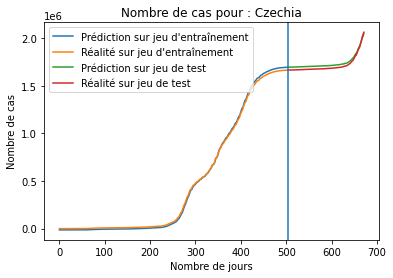

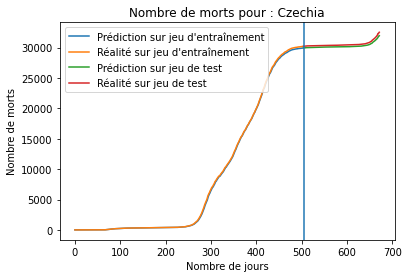

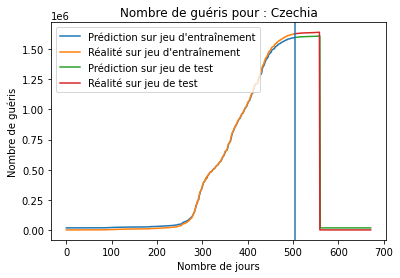

In [19]:
def create_other_country_lstm_sets(country, raw_dataset, n_features=1):
  df_other = selectCountry(raw_dataset, country)
  df_other = removeUselessColumns(df_other)
  columnsInNumbers(df_other)
  X_other = df_other.values[0]
  X_other = np.reshape(X_other, (len(X_other), n_features))
  return create_lstm_sets(X_other, time_steps)

confirmed_train_other, confirmed_test_other, confirmed_scaler_other = create_other_country_lstm_sets("Czechia", df_raw_confirmed_global)
confirmed_train_otherX, confirmed_train_otherY = confirmed_train_other
confirmed_test_otherX, confirmed_test_otherY = confirmed_test_other
display_plot_lstm(confirmed_lstm, confirmed_scaler_other, confirmed_train_otherX, confirmed_train_otherY, confirmed_test_otherX, confirmed_test_otherY, "Czechia", "cas")

deaths_train_other, deaths_test_other, deaths_scaler_other = create_other_country_lstm_sets("Czechia", df_raw_deaths_global)
deaths_train_otherX, deaths_train_otherY = deaths_train_other
deaths_test_otherX, deaths_test_otherY = deaths_test_other
display_plot_lstm(deaths_lstm, deaths_scaler_other, deaths_train_otherX, deaths_train_otherY, deaths_test_otherX, deaths_test_otherY, "Czechia", "morts")

recovered_train_other, recovered_test_other, recovered_scaler_other = create_other_country_lstm_sets("Czechia", df_raw_recovered_global)
recovered_train_otherX, recovered_train_otherY = recovered_train_other
recovered_test_otherX, recovered_test_otherY = recovered_test_other
display_plot_lstm(recovered_lstm, recovered_scaler_other, recovered_train_otherX, recovered_train_otherY, recovered_test_otherX, recovered_test_otherY, "Czechia", "guéris")

## Variable multidimensionelle

### Nouveau dataset de l'age > 65

In [20]:
df_raw_pop = pd.read_csv("population_65.csv", sep=";", encoding='cp1252')

cols = df_raw_pop.columns.to_list()
cols[0] = "Country_Name"
df_raw_pop.columns = cols

def get_country_pop_65_percent(country):
  val = df_raw_pop.query("Country_Name == '" + country + "'").values[0]
  res = val[len(val)-1].replace(",", ".")
  return float(res)

FileNotFoundError: [Errno 2] No such file or directory: 'population_65.csv'

-----------------------------

In [ ]:
time_steps = 5
n_features = 3

### Création des sets individuels mis à l'échelle

In [ ]:
confirmed_lstm_set = df_confirmed_country.values[0]
confirmed_lstm_set = np.reshape(confirmed_lstm_set, (confirmed_lstm_set.shape[0], 1))

deaths_lstm_set = df_deaths_country.values[0]
deaths_lstm_set = np.reshape(deaths_lstm_set, (deaths_lstm_set.shape[0], 1))

age_percent = get_country_pop_65_percent("France")

confirmed_scaler = MinMaxScaler((-1, 1))
deaths_scaler = MinMaxScaler((-1, 1))

confirmed_scaler.fit(confirmed_lstm_set)
deaths_scaler.fit(deaths_lstm_set)

scaled_confirmed = confirmed_scaler.transform(confirmed_lstm_set)
scaled_deaths = deaths_scaler.transform(deaths_lstm_set)

### Création des triplets (cas, morts, % age >65)

In [ ]:
def lstm_network_multi(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(300, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.2))
  model.add(kr.layers.LSTM(300))
  model.add(kr.layers.Dropout(0.2))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=75, batch_size=6);
  return model

In [ ]:
triplets = list(zip(np.reshape(scaled_deaths, (-1,)), np.reshape(scaled_confirmed, (-1,)), [age_percent for _ in range(len(scaled_confirmed))]))

In [ ]:
multivar_train, multivar_test, _ = create_lstm_sets(triplets, time_steps, scale=False)
multivar_trainX, multivar_trainY = multivar_train
multivar_testX, multivar_testY = multivar_test

multivar_lstm = lstm_network_multi(multivar_trainX, multivar_trainY, time_steps, n_features)

In [ ]:
display_plot_lstm(multivar_lstm, deaths_scaler, multivar_trainX, multivar_trainY, multivar_testX, multivar_testY, COUNTRY, "morts")

In [ ]:
calc_error_lstm(multivar_lstm, deaths_scaler, multivar_testX, multivar_testY)